**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from types import SimpleNamespace
from copy import deepcopy
import time

from scipy import optimize
from scipy import linalg

import sympy as sm
from sympy import symbols, sqrt, latex
from scipy.optimize import fsolve
from scipy.optimize import minimize

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [2]:
defaults = {
    'alpha': 0.5,
    'kappa': 1.0,
    'nu': 1/(2 * 16**2),
    'w': 1.0,
    'tau': 0.30
}

In [3]:
#Symbols
alpha = sm.symbols('alpha')
kappa = sm.symbols('kappa')
nu = sm.symbols('nu')
w = sm.symbols('w')
tau = sm.symbols('tau')
G = sm.symbols('G') 
C = sm.symbols('C')
L = sm.symbols('L')
w_tilde = sm.symbols('wtilde')

In [4]:
# Objective function - Utility
utility = sm.log(C**alpha * G**(1-alpha)) - nu * L**2 / 2
print('Utility:')
display(utility)

# Budget Constraint
budget_constraint = kappa + w_tilde * L
print('Budget constraint:')
display(budget_constraint)

# Substituting the budget constraint into the utility function
utility_wrt_L = utility.subs(C, budget_constraint)

# Differentiating with respect to L
foc = sm.diff(utility_wrt_L, L)
solutions = sm.solve(foc, L)
print('Solutions:')
for sol in solutions: display(sol)

Utility:


-L**2*nu/2 + log(C**alpha*G**(1 - alpha))

Budget constraint:


L*wtilde + kappa

Solutions:


(-kappa*nu - sqrt(nu*(4*alpha*wtilde**2 + kappa**2*nu)))/(2*nu*wtilde)

(-kappa*nu + sqrt(nu*(4*alpha*wtilde**2 + kappa**2*nu)))/(2*nu*wtilde)

There are two possible solutions to the first order condition given by the positive and the negative root. 

To verify the optimal value, we have to run the following simulations :

In [5]:
# Defining the parametric values for choosing the valid solution
param_values_1 = {alpha: 0.5, G: 1, nu: 1/(2 * 16**2), w_tilde: 0.70, kappa: 1}

# Evaluate the solutions and pick the non-negative one
L_star_1 = [sol for sol in solutions if sol.evalf(subs=param_values_1)>=0]

display(L_star_1[0])

(-kappa*nu + sqrt(nu*(4*alpha*wtilde**2 + kappa**2*nu)))/(2*nu*wtilde)

In [6]:
# Defining the parametric values for choosing the valid solution
param_values_2 = {alpha: 0.5, G: 2, nu: 1/(2 * 16**2), w_tilde: 0.70, kappa: 1}

# Evaluate the solutions and pick the non-negative one
L_star_2 = [sol for sol in solutions if sol.evalf(subs=param_values_2)>=0]

display(L_star_2[0])

(-kappa*nu + sqrt(nu*(4*alpha*wtilde**2 + kappa**2*nu)))/(2*nu*wtilde)

Calculating the first order derivative with both values of G, we get the same solution, the positive root, which is coherent with the proposed answer. Hence, proved.

In [7]:
L_star = L_star_1[0]

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

In [8]:
#Establishing the function
L_star_wrt_w = L_star.subs(w_tilde, (1 - tau)*w)
_L_star_fn = sm.lambdify((w, tau, kappa, nu, alpha), L_star_wrt_w) 
L_star_fn = lambda w, tau: _L_star_fn(w, tau, defaults['kappa'], defaults['nu'], defaults['alpha'])

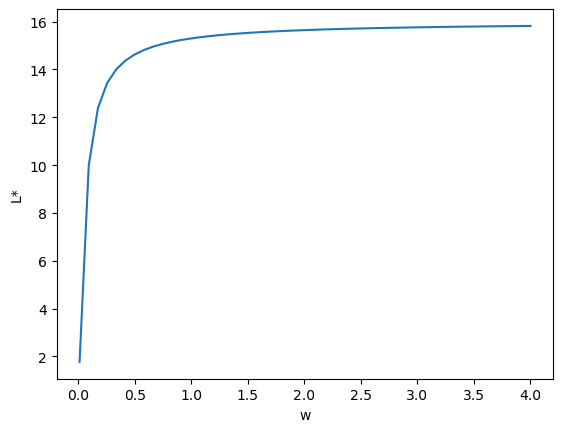

In [9]:
#Plotting labour hours against varying wage
ws = np.linspace(0.01,4,50)
Ls = L_star_fn(ws, defaults['tau'])
plt.ylabel('L*')
plt.xlabel('w')
plt.plot(ws, Ls)


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


In [10]:
govt_cons = tau*w*L
_govt_cons_fn = sm.lambdify((tau, L, w), govt_cons)
govt_cons_fn = lambda tau, L: _govt_cons_fn(tau, L, defaults['w'])

In [11]:
utility_wrt_tau = utility_wrt_L.subs(w_tilde, (1 - tau)*w)
_utility_fn = sm.lambdify((tau, L, G, w, alpha, nu, kappa), utility_wrt_tau)
utility_fn = lambda tau, L, G: _utility_fn(tau, L, G, defaults['w'], defaults['alpha'], defaults['nu'], defaults['kappa'])

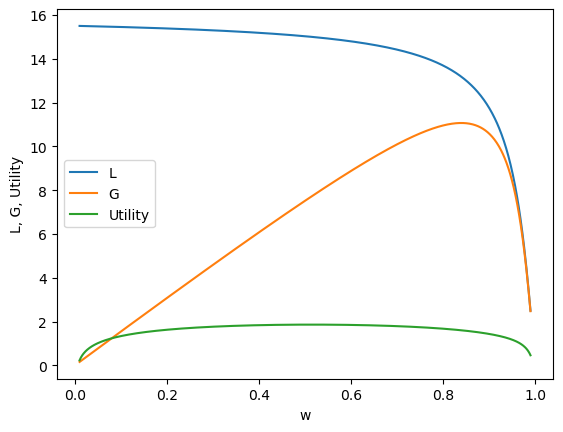

In [12]:
taus = np.linspace(0.01, 0.99, 1000)
L_stars = L_star_fn(defaults['w'], taus)
govt_conses = govt_cons_fn(taus, L_stars)
utils = utility_fn(taus, L_stars, govt_conses)

plt.plot(taus, L_stars, label = 'L')
plt.plot(taus, govt_conses, label = 'G')
plt.plot(taus, utils, label = 'Utility')
plt.xlabel('w')
plt.ylabel('L, G, Utility')
plt.legend()

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

We run the optimisation to find the optimal tax rate for maximising utility :

In [13]:
def obj(tau):
    L_star = L_star_fn(defaults['w'], tau)
    govt_cons = govt_cons_fn(tau, L_star)
    util = utility_fn(tau, L_star, govt_cons)
    return -util

res = optimize.minimize_scalar(obj, bounds=(0.01, 0.99), method='bounded')
print(f"Optimal tax rate is {res.x:.2f}")


Optimal tax rate is 0.51


Illustrating our result graphically, showing the relationship between utility and tax rate tau :

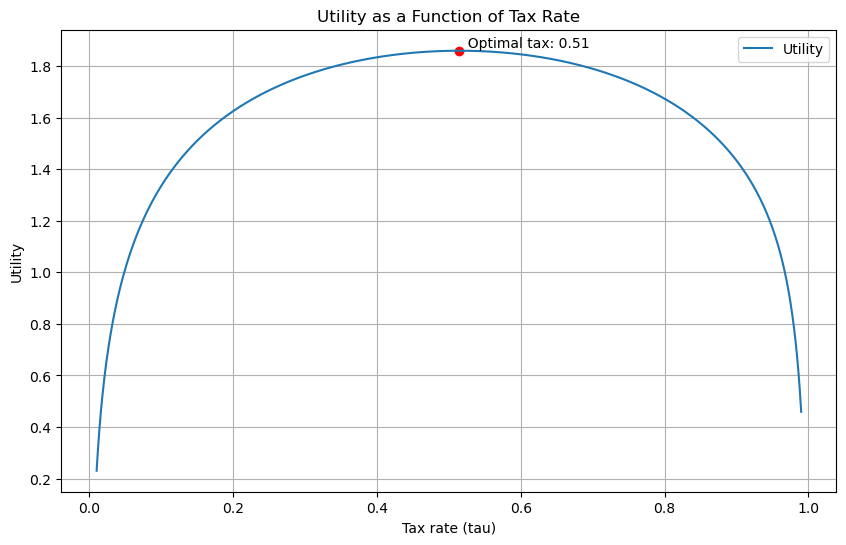

In [14]:

# Calculate utility values for each tax rate
utility_values = [-obj(tau) for tau in taus]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(taus, utility_values, label='Utility')
plt.scatter([res.x], [-obj(res.x)], color='red')  # Mark the optimum
plt.text(res.x, -obj(res.x), f"  Optimal tax: {res.x:.2f}", verticalalignment='bottom')

plt.xlabel('Tax rate (tau)')
plt.ylabel('Utility')
plt.title('Utility as a Function of Tax Rate')
plt.legend()
plt.grid(True)
plt.show()

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [15]:
#Setting up the utility function with new parameters
epsilon = sm.symbols('epsilon')
sigma = sm.symbols('sigma')
rho = sm.symbols('rho')



In [16]:

# Objective function - Utility
utility =  - nu * (L**(1 + epsilon) / (1 + epsilon)) + ((alpha*C**((sigma - 1)/sigma) + (1 - alpha)*G**((sigma)/(sigma - 1)))**(1 - rho) - 1)/ (1 - rho)
budget_constraint = kappa + (1 - tau)*w*L
utility_wrt_L = utility.subs(C, budget_constraint)
focn = sm.diff(utility_wrt_L, L)
print('The first order derivative:')
display(focn)


The first order derivative:


alpha*w*(1 - tau)*(sigma - 1)*(G**(sigma/(sigma - 1))*(1 - alpha) + alpha*(L*w*(1 - tau) + kappa)**((sigma - 1)/sigma))**(1 - rho)*(L*w*(1 - tau) + kappa)**((sigma - 1)/sigma)/(sigma*(G**(sigma/(sigma - 1))*(1 - alpha) + alpha*(L*w*(1 - tau) + kappa)**((sigma - 1)/sigma))*(L*w*(1 - tau) + kappa)) - L**(epsilon + 1)*nu/L

Due to the complexity of the derivative, sympy is unable to isolate L from the equation. To find optimal L and in turn the optimal G based on the tau we have found, we implement the following methodology:

In [17]:
# Set parameter values
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16 ** 2)
w = 1.0
tau = 0.51  # set the tau

#Two sets of values for the new parameters
params_sets = [{'sigma': 1.001, 'rho': 1.001, 'epsilon': 1.0}, 
               {'sigma': 1.5, 'rho': 1.5, 'epsilon': 1.0}]

def utility(L, G, sigma, rho, epsilon):
    C = kappa + (1 - tau) * w * L
    term1 = ((alpha * C ** ((sigma - 1) / sigma) + (1 - alpha) * G ** ((sigma - 1) / sigma)) ** (sigma / (sigma - 1))) ** (1 - rho)
    term2 = nu * L ** (1 + epsilon) / (1 + epsilon)
    return (term1 - 1) / (1 - rho) - term2

def objective(G, sigma, rho, epsilon):
    # Solve for optimal L given tau and G
    L_star_res = minimize(lambda L: -utility(L, G, sigma, rho, epsilon), 
                          x0=8, bounds=((0, 24),))
    if L_star_res.success:
        L_star = L_star_res.x[0]
        # Substitute L_star back into the utility function
        return -utility(L_star, G, sigma, rho, epsilon)
    else:
        return np.inf

for params in params_sets:
    res = minimize(lambda G: objective(G[0], **params), x0=[4], bounds=((0, 12.24),))  
    if res.success:
        print(f"Optimal G for params {params} is {res.x[0]}")
    else:
        print(f"Optimization failed for params {params}")

Optimal G for params {'sigma': 1.001, 'rho': 1.001, 'epsilon': 1.0} is 4.2057020788437764
Optimal G for params {'sigma': 1.5, 'rho': 1.5, 'epsilon': 1.0} is 12.239999690398603


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [18]:
# Using the already established parametric values, with the obvious exception of tau

def utility(L, tau, G, sigma, rho, epsilon):
    C = kappa + (1 - tau) * w * L
    term1 = ((alpha * C ** ((sigma - 1) / sigma) + (1 - alpha) * G ** ((sigma - 1) / sigma)) ** (sigma / (sigma - 1))) ** (1 - rho)
    term2 = nu * L ** (1 + epsilon) / (1 + epsilon)
    return (term1 - 1) / (1 - rho) - term2

def objective(tau, sigma, rho, epsilon):
    # Solve for optimal L given tau and G
    L_star_res = minimize(lambda L: -utility(L, tau, tau * w * L, sigma, rho, epsilon), 
                          x0=8, bounds=((0, 24),))
    if L_star_res.success:
        L_star = L_star_res.x[0]
        # Substitute L_star back into the utility function
        return -utility(L_star, tau, tau * w * L_star, sigma, rho, epsilon)
    else:
        return np.inf

for params in params_sets:
    res = minimize(lambda tau: objective(tau[0], **params), x0=[0.5], bounds=((0, 1),))
    if res.success:
        print(f"Optimal tax rate for params {params} is {res.x[0]}")
    else:
        print(f"Optimization failed for params {params}")


Optimal tax rate for params {'sigma': 1.001, 'rho': 1.001, 'epsilon': 1.0} is 0.4999999999998455
Optimal tax rate for params {'sigma': 1.5, 'rho': 1.5, 'epsilon': 1.0} is 0.5374814333482609


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

Define symbols and constants.

In [19]:
l_t = sm.symbols('l_t')
y_t = sm.symbols('y_t')
w = sm.symbols('w')
p_t = sm.symbols('p_t')
kappa_t = sm.symbols('kappa_t')
eta = sm.symbols('eta')

In [20]:
W = 1.0
ETA = 0.5
KAPPA_T = 1.0

Derive analytical solution:

In [21]:
profit = kappa_t * l_t**(1-eta) - w*l_t

foc = sm.Eq(0, sm.diff(profit, l_t))
optimal_l_t = sm.solve(foc, l_t)

In [22]:
assert(len(optimal_l_t)==1)
optimal_l_t = optimal_l_t[0]

print('Analytically determined optimal labour:')
display(optimal_l_t)

Analytically determined optimal labour:


(kappa_t*(1 - eta)/w)**(1/eta)

Find numerical solution for $l_t$ which maximises profit $\Pi$ for $\kappa \in \{1.0, 2.0\}$ 

Compare with analytical solution.

In [23]:
_optimal_lt_fn = sm.lambdify((kappa_t, eta, w), optimal_l_t)
def optimal_lt_fn(kappa_t=KAPPA_T, eta=ETA, w=W):
    return _optimal_lt_fn(kappa_t, eta, w)

In [24]:
_profit_fn = sm.lambdify((l_t, w, kappa_t, eta), profit)
def profit_fn(l_t, w=W, kappa_t=KAPPA_T, eta=ETA):
    return _profit_fn(l_t, w, kappa_t, eta)

In [25]:
def obj(l_t, kappa_t):
    return -profit_fn(l_t=l_t, kappa_t=kappa_t)

for kappa in [1.0, 2.0]:
    res = optimize.minimize_scalar(obj, args=kappa)
    analytical_sol = optimal_lt_fn(kappa_t=kappa)
    print(f'kappa_t = {kappa}    Numerical Sol: {res.x:5.3f}    Analytical Sol: {analytical_sol: 5.3f}    Same? {np.isclose(analytical_sol, res.x)}')

kappa_t = 1.0    Numerical Sol: 0.250    Analytical Sol:  0.250    Same? True
kappa_t = 2.0    Numerical Sol: 1.000    Analytical Sol:  1.000    Same? True


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

Define further constants:

In [26]:
RHO = 0.90
IOTA = 0.01
SIGMA_EPS = 0.10
MU_EPS = -0.5 * SIGMA_EPS**2
KAPPA_INIT = 1
R = (1 + 0.01)**(1 / 12)
T = 120

Define function to produce a series of demand shocks. This series can then be used to calculate the _ex post_ value of the salon dependent on a particular set of shocks:

In [27]:
def get_demand_shocks():
    epsilons = np.random.normal(MU_EPS, SIGMA_EPS, size=T)
    log_kappas = np.empty(T)

    for t in range(T):
        log_kappa_lag = np.log(KAPPA_INIT) if t==0 else log_kappas[t-1]
        log_kappas[t] = RHO * log_kappa_lag + epsilons[t] 

    return np.exp(log_kappas)

Define functions to calculate:
1. the _ex post_ value conditional on a labour policy and series of demand shocks
2. an approximation of the _ex ante_ expected value, which involves taking the average of many _ex post_ values over different sets of shocks 

In [28]:
def ex_post_value(labour_policy, demand_shocks):
    present_value = 0
    labour_lag = 0

    for t in range(T):
        demand_shock = demand_shocks[t]
        labour = labour_policy({
            'demand_shock': demand_shock,
            'labour_lag': labour_lag
            })

        income = demand_shock*labour**(1 - ETA)
        labour_cost = W*labour 
        adjustment_cost = (labour_lag!=labour)*IOTA

        discounted_value = R**(-t) * (income - labour_cost - adjustment_cost)
        present_value += discounted_value

        labour_lag = labour

    return present_value 

In [29]:
def ex_ante_value(labour_policy=None, K=1000):
    approximate_value = 0
    for k in range(K):
        demand_shocks = get_demand_shocks()
        approximate_value += ex_post_value(labour_policy, demand_shocks)
    return approximate_value / K

Define function to represent the analytical solution as a labour policy:

In [30]:
def analytical_labour(params):
    return optimal_lt_fn(kappa_t=params['demand_shock'])

Explore convergence of the _ex ante_ expected value as K increases:

In [31]:
ks = np.logspace(0, 3, 30)
hs = [ex_ante_value(labour_policy=analytical_labour, K=int(k)) for k in ks]

[Text(0.5, 1.0, 'Convergence of ex ante expected value in K'),
 Text(0.5, 0, 'K'),
 None,
 Text(0, 0.5, 'ex ante expected value')]

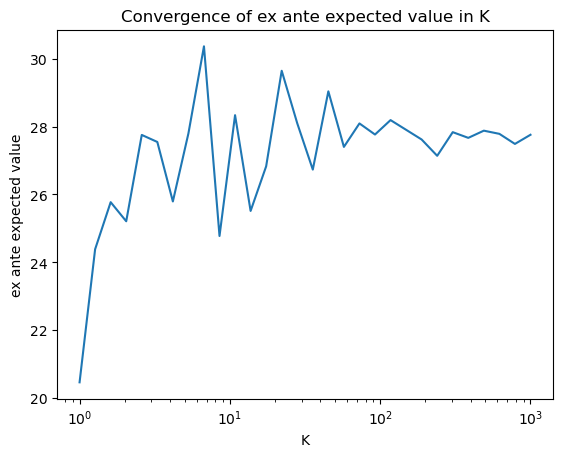

In [32]:
ax = plt.subplot()
ax.plot(ks, hs)
ax.set(title='Convergence of ex ante expected value in K', xlabel='K', xscale='log', ylabel='ex ante expected value')

Thus, choosing K=1000, calculate the _ex ante_ expected value of the salon using the analytical labour policy:

In [33]:
H_analytical = ex_ante_value(labour_policy=analytical_labour, K=1000)
print(f'Ex ante expected value (H) with analytical labour policy\n~= {H_analytical:6.4f}')

Ex ante expected value (H) with analytical labour policy
~= 27.9603


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

Define a function to produce a 'delta policy', which only updates labour when optimal labour is adequately different from the current labour choice.

Produce such a policy with $\Delta = 0.05$ and approximate the _ex ante_ expected value of the salon, conditional on this labour policy.

In [34]:
def get_delta_policy(Delta):

    def delta_policy(params):
        optimal_labour = optimal_lt_fn(kappa_t=params['demand_shock'])
        labour_lag = params['labour_lag']

        delta_exceeded = np.abs(labour_lag - optimal_labour) > Delta
        return optimal_labour if delta_exceeded else labour_lag

    return delta_policy

In [35]:
H_delta_05 = ex_ante_value(labour_policy=get_delta_policy(0.05))
print(f'Ex ante expected value (H) with delta labour policy, and Delta=0.05\n~= {H_delta_05:6.4f}')
print(f'Profitability improved? {H_delta_05 > H_analytical}')

Ex ante expected value (H) with delta labour policy, and Delta=0.05
~= 28.2425
Profitability improved? True


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

Define an objective function which chooses $\Delta$ to maximise the _ex ante_ expected value of the salon. 

In [36]:
Deltas = []
Hs = []
solution_Deltas = []
solution_Hs = []

def obj(Delta):
    H = ex_ante_value(labour_policy=get_delta_policy(Delta))
    Deltas.append(Delta)
    Hs.append(H)
    return -H

Perform the optimisation multiple times to handle the noisiness of the approximation function, and take the average of the returned solutions. Additionally calculate a low-accuracy 'sketch' series to visualise the broader optimisation problem.

In [37]:
for i in range(5):
    res = optimize.minimize_scalar(obj, method='Bounded', bounds=(0, 1))
    solution_Deltas.append(res.x)
    solution_Hs.append(-res.fun)

In [38]:
Delta_optimal = np.mean(solution_Deltas)

In [39]:
sketch_Deltas = np.linspace(0, 1, 30)
sketch_Hs = [ex_ante_value(labour_policy=get_delta_policy(Delta), K=50) for Delta in sketch_Deltas]

Illustrate the optimisation problem:

[Text(0.5, 1.0, 'Close-up'), (0.0, 0.25), (25.0, 30.0)]

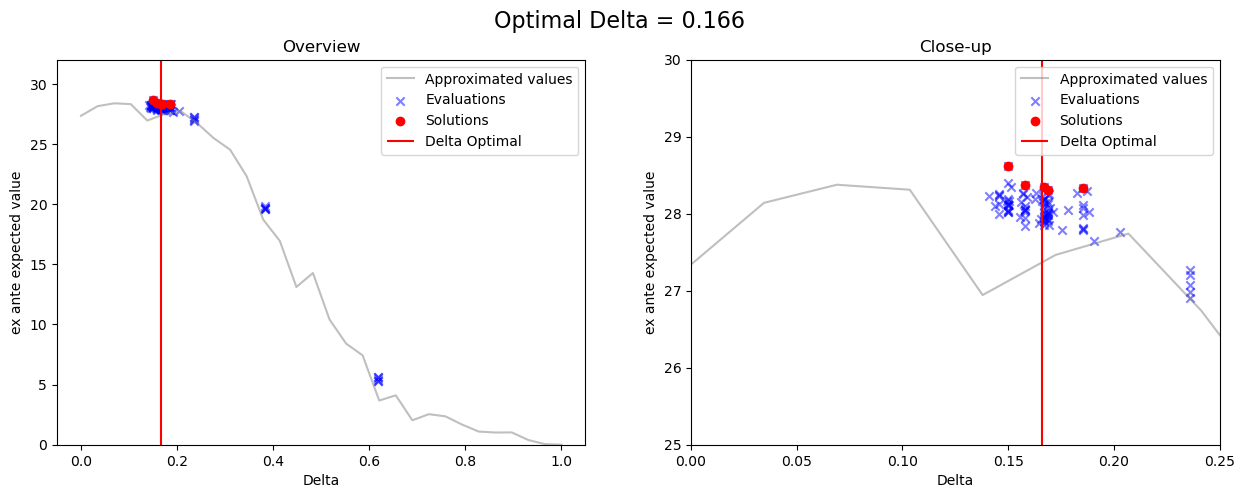

In [40]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
for ax in axs:
    ax.plot(sketch_Deltas, sketch_Hs, c='grey', alpha=0.5, label='Approximated values')
    ax.scatter(Deltas, Hs, c='blue', alpha=0.5, marker='x', label='Evaluations')
    ax.scatter(solution_Deltas, solution_Hs, c='red', label='Solutions')
    ax.vlines(Delta_optimal, -5, 35, colors='red', label='Delta Optimal')
    ax.set(xlabel='Delta', ylabel='ex ante expected value')
    ax.legend()

fig.suptitle(f'Optimal Delta = {Delta_optimal:4.3f}', fontsize=16)
axs[0].set(title='Overview', ylim=(0,32))
axs[1].set(title='Close-up', xlim=(0,0.25), ylim=(25,30))


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [41]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [42]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [43]:
def refined_optimizer(K=1000 , K_underbar=10, tau=1e-8, do_print=False):
    """
    Minimize the griewank function using a refined global optimiser.
    """

    # Set random seed to generate replicable behaviour
    np.random.seed(2023)

    # Gather initial random draws
    x0s = -600 + 1200*np.random.uniform(size=(K,2)) # Set bounds to [-600, 600]

    # Allocate arrays to store optimiser's behaviour
    xk0s = np.empty(x0s.shape)
    x_stars = np.empty(x0s.shape)
    f_stars = np.empty(K)
    x_star = np.nan
    f_star = np.inf

    # Loop through K iterations
    for k in range(K):

        # A. Draw random xk (from array of random draws)
        xk = x0s[k]

        # B. When k < K_underbar, set initial guess to random draw.
        if k < K_underbar :
            xk0 = xk

        # C. D. Calculate chi_k and effective initial guess
        else :
            chi_k = 0.50 * 2 / (1 + np.exp((k - K_underbar)/100))
            xk0 = chi_k*xk + (1 - chi_k)*x_star
        xk0s[k] = xk0

        # E. Run optimiser
        res = optimize.minimize(griewank, xk0, method='BFGS', tol=tau)
        xk_star = res.x 
        fk_star = res.fun

        # F. If this is the best solution so far, save result
        if fk_star < f_star:
            f_star = fk_star
            x_star = xk_star
            if do_print: 
                if k == 0: print(f'{"k":>3}   {"xk":>18}   {"xk0":>18}   {"x_star":>22}   {"f_star":>6}')
                print(f'{k:3}   [{xk[0]:+7.2f}, {xk[1]:+7.2f}]   [{xk0[0]:7.2f}, {xk0[1]:7.2f}]   [{x_star[0]:9.4f}, {x_star[1]:9.4f}]   {f_star:5.3f}')

        # Æ. Additionally store current optimal solution for all k
        f_stars[k] = f_star
        x_stars[k] = x_star

        # G. If f_star < tolerance, break loop and return dictionary
        if f_star < tau :
            break
    return {'x_star': x_star, 'f_star': f_star, 'k': k, 'x0s' : x0s, 'xk0s' : xk0s, 'x_stars' : x_stars, 'fk_stars' : f_stars, 'K' : K, 'K_underbar' : K_underbar}
    

Running the optimisation:

In [44]:
res = refined_optimizer(do_print=True)

  k                   xk                  xk0                   x_star   f_star
  0   [-213.61, +468.51]   [-213.61,  468.51]   [-213.5148,  470.4628]   66.795
  1   [+105.66, -448.08]   [ 105.66, -448.08]   [ 103.6179, -448.2743]   52.975
  2   [-430.39,  -38.53]   [-430.39,  -38.53]   [-430.1813,  -39.9450]   46.687
  4   [ +29.26,  +53.92]   [  29.26,   53.92]   [  31.4002,   53.2613]   0.957
  5   [ -52.35,   +1.66]   [ -52.35,    1.66]   [ -50.2404,   -0.0000]   0.631
 33   [ -19.67,  +18.27]   [ -36.71,    8.09]   [ -37.6803,    8.8769]   0.375
103   [+107.48,  -15.23]   [   3.39,    2.06]   [   3.1400,    4.4384]   0.007
319   [-127.97, -158.30]   [  -2.57,   -2.64]   [  -3.1400,   -4.4384]   0.007
352   [  -2.62, +172.18]   [  -3.12,    1.16]   [  -3.1400,    4.4384]   0.007
374   [ +61.25,  -88.35]   [  -1.49,    2.06]   [  -0.0000,    0.0000]   0.000


Illustrating convergence of effective initial guesses over k:

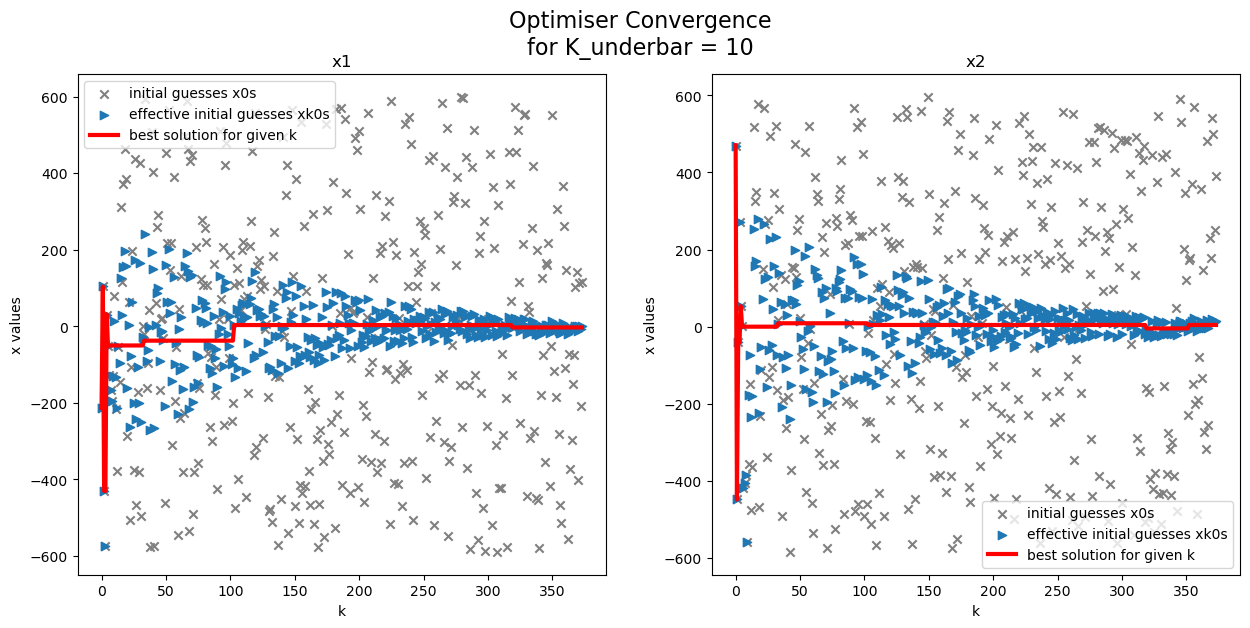

In [45]:
def plot_convergence(res):
    fig, axs = plt.subplots(1,2,figsize=(15,6.5))
    fig.suptitle('Optimiser Convergence\nfor K_underbar = '+str(res['K_underbar']), fontsize=16)
    for i in range(2):
        axs[i].scatter(range(res['k']), res['x0s'][:res['k'],i], label='initial guesses x0s', marker='x', c='grey')
        axs[i].scatter(range(res['k']), res['xk0s'][:res['k'],i], label='effective initial guesses xk0s', marker='>')
        axs[i].plot(range(res['k']), res['x_stars'][:res['k'],i], label='best solution for given k', c='red', lw=3)
        axs[i].set(title='x'+str(i+1), xlabel='k', ylabel='x values')
        axs[i].legend()

plot_convergence(res)


**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

Exploring case where K_underbar = 100

  k                   xk                  xk0                   x_star   f_star
  0   [-213.61, +468.51]   [-213.61,  468.51]   [-213.5148,  470.4628]   66.795
  1   [+105.66, -448.08]   [ 105.66, -448.08]   [ 103.6179, -448.2743]   52.975
  2   [-430.39,  -38.53]   [-430.39,  -38.53]   [-430.1813,  -39.9450]   46.687
  4   [ +29.26,  +53.92]   [  29.26,   53.92]   [  31.4002,   53.2613]   0.957
  5   [ -52.35,   +1.66]   [ -52.35,    1.66]   [ -50.2404,   -0.0000]   0.631
 33   [ -19.67,  +18.27]   [ -19.67,   18.27]   [ -18.8401,   17.7538]   0.168
147   [ +39.02,  -63.85]   [   3.42,  -13.63]   [   3.1400,  -13.3153]   0.047
272   [ -50.01,  +53.27]   [  -4.93,   -3.20]   [  -3.1400,   -4.4384]   0.007
352   [  -2.62, +172.18]   [  -3.10,    8.71]   [   0.0000,   -0.0000]   0.000


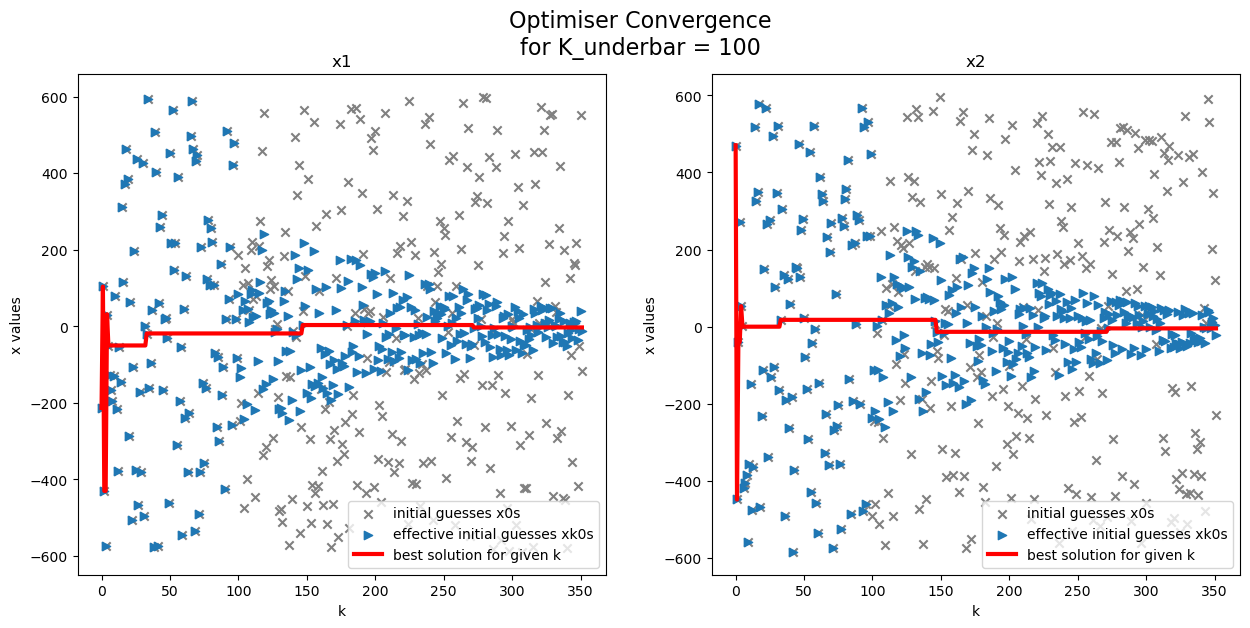

In [46]:
res = refined_optimizer(K_underbar = 100, do_print = True)
plot_convergence(res)


Running the optimization with K_underbar = 100, we see that we need 352 iterations for the functional value to converge to the target 0. In the case of K_underbar = 10, we needed 368. In this direct comparison, it is a better idea to use 100 instead of 10. However, using 100 is not necessarily the optimum since the relationship between the number of final iterations and number of warm up iterations is arbitrary, given the random generator we use. In the next two examples, setting K_underbar to 5 and 54 respectively, we see the number of iterations required is 342 and 272 respectively, therefore justifying our claim.

The K_underbar phase does however represent an exploratative phase which could, in theory and under other random generators, accelerate the rate of convergence, allowing the exploitative phase to hone in on superior solutions.

  k                   xk                  xk0                   x_star   f_star
  0   [-213.61, +468.51]   [-213.61,  468.51]   [-213.5148,  470.4628]   66.795
  1   [+105.66, -448.08]   [ 105.66, -448.08]   [ 103.6179, -448.2743]   52.975
  2   [-430.39,  -38.53]   [-430.39,  -38.53]   [-430.1813,  -39.9450]   46.687
  4   [ +29.26,  +53.92]   [  29.26,   53.92]   [  31.4002,   53.2613]   0.957
  5   [ -52.35,   +1.66]   [ -10.48,   27.46]   [ -12.5601,   26.6307]   0.217
 33   [ -19.67,  +18.27]   [ -15.62,   23.03]   [ -15.7001,   22.1922]   0.185
103   [+107.48,  -15.23]   [  17.91,   11.98]   [  15.7001,   13.3153]   0.106
147   [ +39.02,  -63.85]   [  20.24,   -1.71]   [  18.8401,    0.0000]   0.089
183   [-228.56,  +26.47]   [ -16.86,    3.82]   [ -15.7001,    4.4384]   0.067
191   [+187.97,   +9.60]   [  11.73,    5.13]   [   9.4201,    4.4384]   0.027
210   [ -94.24,  +50.83]   [  -2.40,    9.73]   [  -0.0000,    8.8769]   0.020
319   [-127.97, -158.30]   [  -5.31,    1.94]   

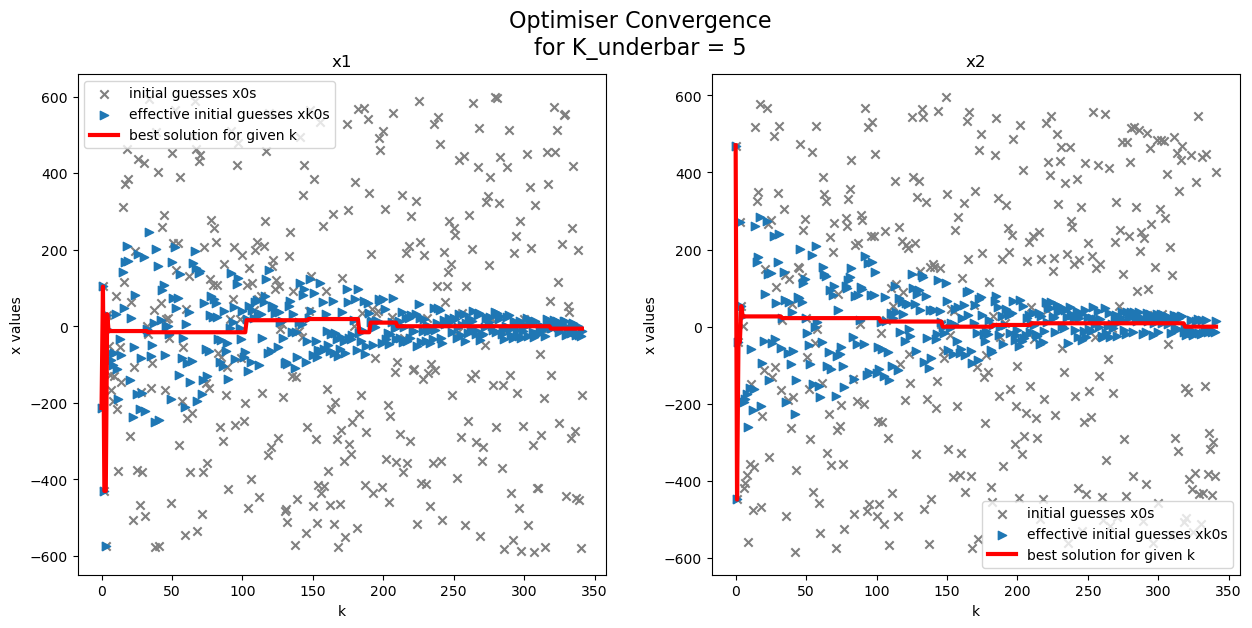

In [47]:
res = refined_optimizer(K_underbar = 5, do_print = True)
plot_convergence(res)

  k                   xk                  xk0                   x_star   f_star
  0   [-213.61, +468.51]   [-213.61,  468.51]   [-213.5148,  470.4628]   66.795
  1   [+105.66, -448.08]   [ 105.66, -448.08]   [ 103.6179, -448.2743]   52.975
  2   [-430.39,  -38.53]   [-430.39,  -38.53]   [-430.1813,  -39.9450]   46.687
  4   [ +29.26,  +53.92]   [  29.26,   53.92]   [  31.4002,   53.2613]   0.957
  5   [ -52.35,   +1.66]   [ -52.35,    1.66]   [ -50.2404,   -0.0000]   0.631
 33   [ -19.67,  +18.27]   [ -19.67,   18.27]   [ -18.8401,   17.7538]   0.168
123   [ +97.74,  -71.10]   [  20.10,  -11.93]   [  21.9802,  -13.3153]   0.165
210   [ -94.24,  +50.83]   [   1.80,   -2.18]   [   3.1400,   -4.4384]   0.007
272   [ -50.01,  +53.27]   [  -2.26,    1.42]   [  -0.0000,   -0.0000]   0.000


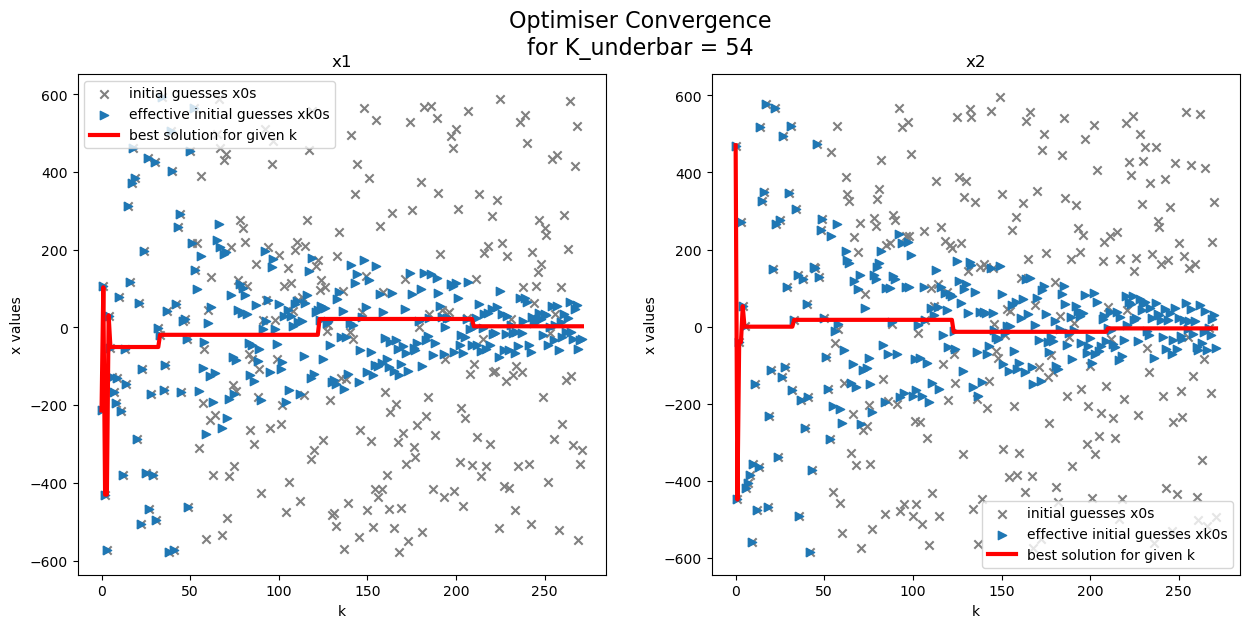

In [48]:
res = refined_optimizer(K_underbar = 54, do_print = True)
plot_convergence(res)